## Алиман Максытбекова
## Финальный проект на курсе "Аналитик данных" от Karpov.Courses: вариант 2

In [1]:
import pandas as pd

### Задание 1

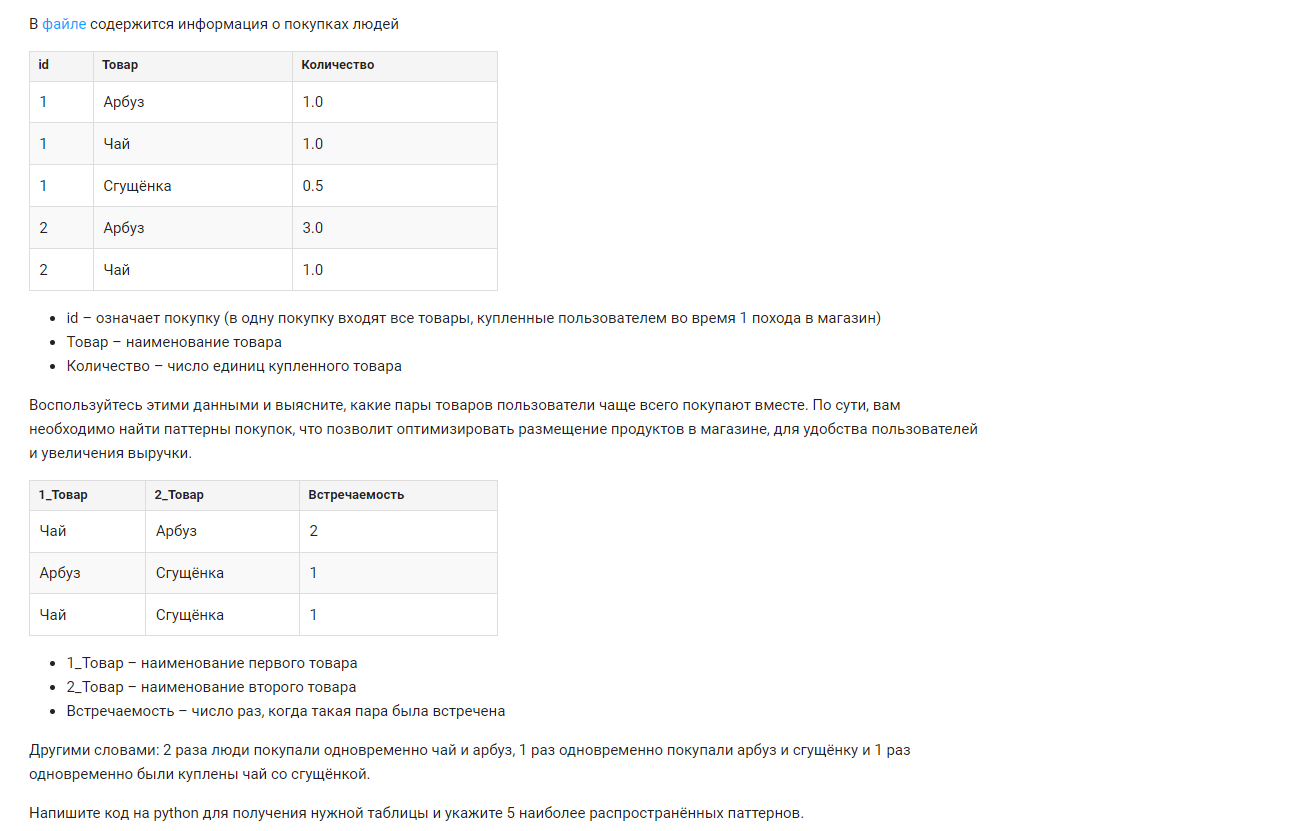

[Файл](https://stepik.org/media/attachments/lesson/409319/test1_completed.csv)

In [2]:
from itertools import combinations
from collections import Counter

In [3]:
# Функция для нахождения пар товаров, которые чаще всего покупают вместе
def bought_together(path_as_string):
    df = pd.read_csv(path_as_string).rename(columns={'Товар': 'Item'})
    counter = Counter([tuple(sorted(i)) for key, item in df.groupby('id').Item for i in combinations(item, 2)]).most_common()
    d_one = pd.DataFrame(counter, columns=['item_tuples', 'frequency'])
    d_two = pd.DataFrame(d_one['item_tuples'].tolist(), columns=['1_Товар', '2_Товар'])
    d_two['Встречаемость'] = d_one.frequency
    return d_two

In [4]:
bought_together('https://stepik.org/media/attachments/lesson/409319/test1_completed.csv').head()

,1_Товар,2_Товар,Встречаемость
0,Огурцы Луховицкие,Укроп,431
1,Петрушка,Укроп,408
2,Арбуз,Огурцы Луховицкие,345
3,Кабачки,Огурцы Луховицкие,326
4,Кинза,Укроп,303


##### Вывод:
Чаще всего вместе покупают следующие пары товаров:
- Огурцы Луховицкие - Укроп
- Петрушка - Укроп
- Арбуз - Огурцы Луховицкие
- Кабачки - Огурцы Луховицкие
- Кинза - Укроп

Так как большинство товаров из полученных пар сезонные и являются особенно популярными в конце лета-начале осени, их попадание в список наиболее часто покупаемых продуктов в этот период ожидаемо. Можно снизить вес сезонных товаров, чтобы получить менее привязанный к времени года результат.

### Задание 2

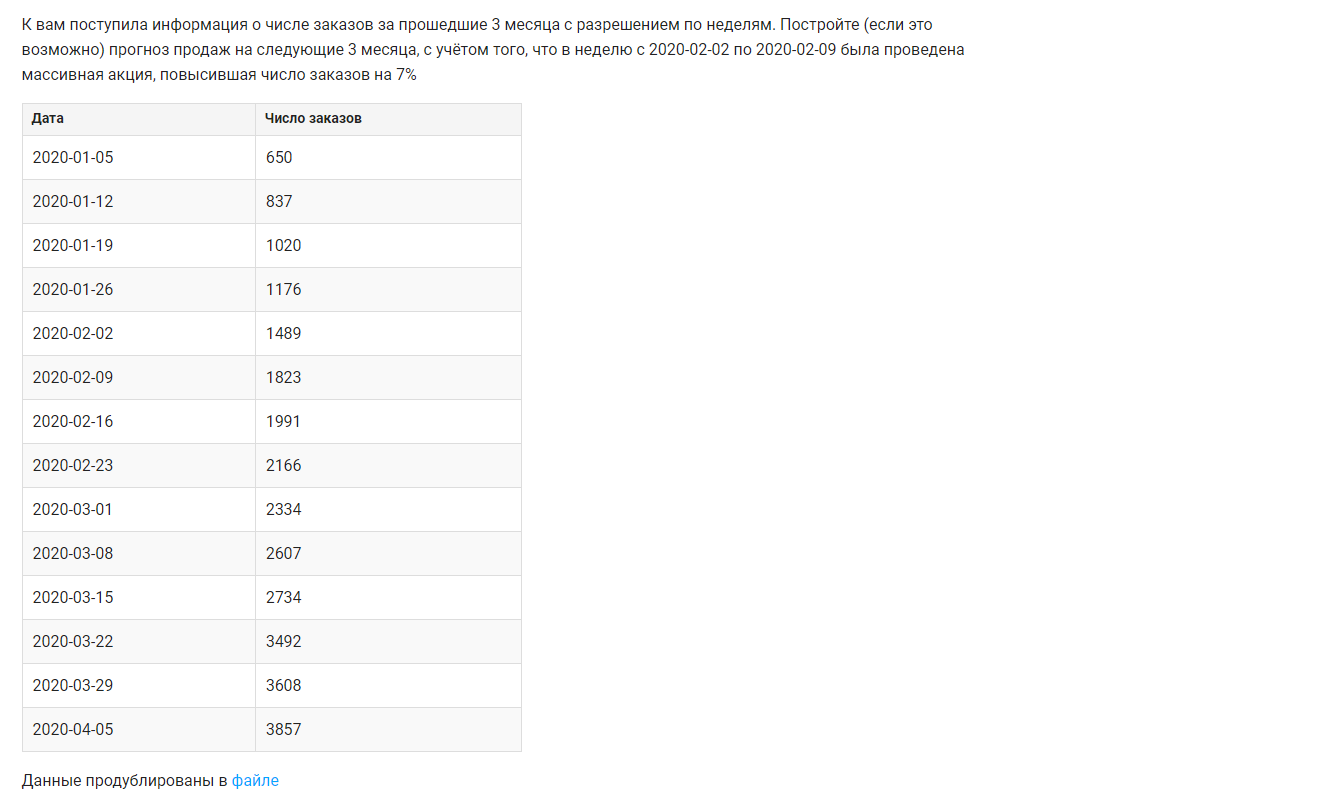

[Файл](https://stepik.org/media/attachments/lesson/426638/test2_completed.csv)

Данных очень мало, прослеживается линейный тренд. Я буду использовать facebook prophet для построение прогноза.

In [5]:
from fbprophet import Prophet
import seaborn as sns

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (20, 12)}
    )

In [6]:
df2 = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv') \
        .rename(columns={'Дата': 'ds', 'Число заказов': 'y'})
df2['ds'] = pd.to_datetime(df2.ds)

In [7]:
# Создаем объект класса Prophet, тренируем его и строим прогноз
m = Prophet().fit(df2)

future = m.make_future_dataframe(periods=13, freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


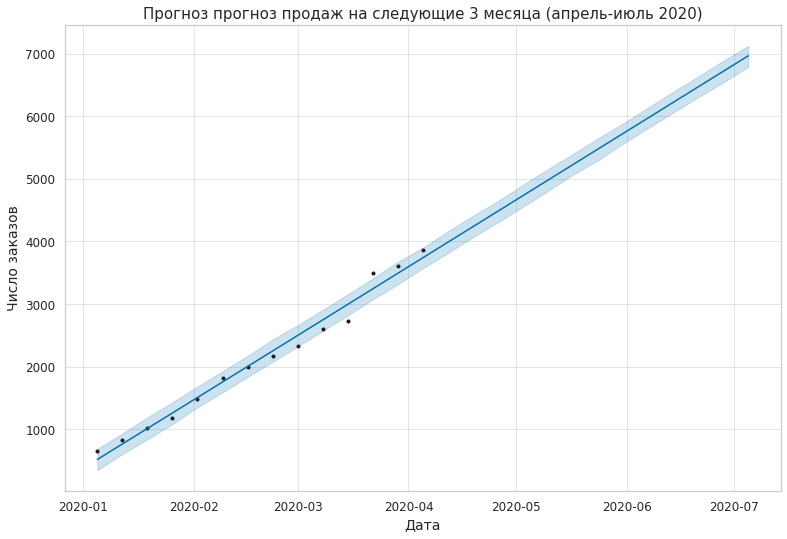

In [8]:
fig = m.plot(forecast, figsize=(12, 8))
ax = fig.gca()
ax.set_title("Прогноз прогноз продаж на следующие 3 месяца (апрель-июль 2020)", size=15)
ax.set_xlabel("Дата", size=14)
ax.set_ylabel("Число заказов", size=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

### Задание 3

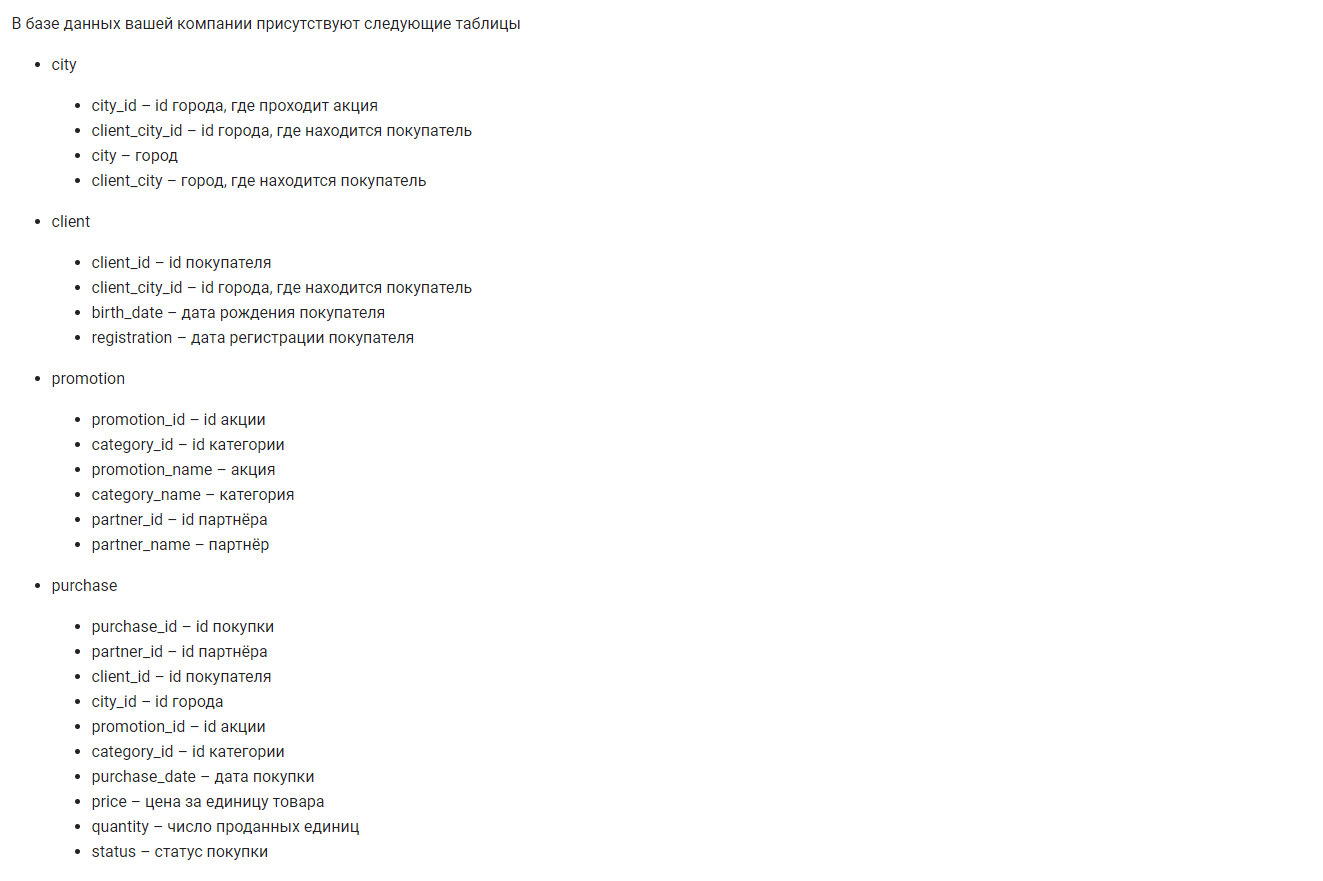
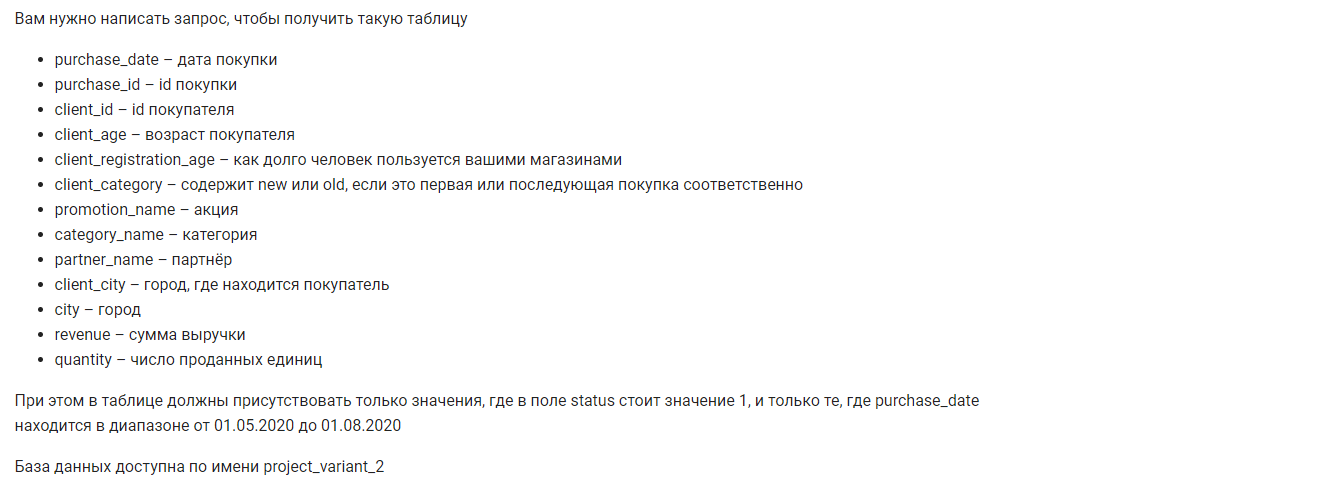

In [9]:
import pandahouse as ph

connection_project_variant_2 = {'host': 'http://clickhouse.beslan.pro:8080',
                                'database': 'project_variant_2',
                                'user': 'student', 
                                'password': 'dpo_python_2020'
                                }

In [10]:
q = '''
SELECT 
    purchase.purchase_date AS purchase_date,
    purchase.purchase_id AS purchase_id,
    client.client_id AS client_id,
    toInt32(IF(MONTH(client.birth_date) = toMonth(now())
        AND DAY(client.birth_date) > toDayOfMonth(now())
        OR MONTH(client.birth_date) > toMonth(now()),
        DATE_DIFF(year, client.birth_date, toDate(now())) - 1,
        DATE_DIFF(year, client.birth_date, toDate(now())))) AS client_age,
    concat(toString(intDivOrZero(
        IF(DAY(client.registration) > toDayOfMonth(now()),
        DATE_DIFF(month, client.registration, toDate(now())) - 1,
        DATE_DIFF(month, client.registration, toDate(now()))), 12)),
        ' Y ',
        toString(moduloOrZero(
        IF(DAY(client.registration) > toDayOfMonth(now()),
        DATE_DIFF(month, client.registration, toDate(now())) - 1,
        DATE_DIFF(month, client.registration, toDate(now()))), 12)),
        ' M') AS client_registration_age,
    IF(a.first_purchase = purchase.purchase_date
        AND a.client_id = client.client_id, 'new', 'old') AS client_category,
    promotion.promotion_name AS promotion_name,
    promotion.category_name AS category_name,
    promotion.partner_name AS partner_name,
    city.client_city AS client_city,
    city.city AS city,
    toInt32(purchase.quantity * purchase.price) AS revenue,
    toInt32(purchase.quantity) AS quantity
FROM
    {db}.client
INNER JOIN
    {db}.purchase
ON
    client.client_id = purchase.client_id
INNER JOIN
    {db}.city
ON
    city.city_id = purchase.city_id
    AND client.client_city_id = city.client_city_id
INNER JOIN
    {db}.promotion
ON
    purchase.partner_id = promotion.partner_id
    AND purchase.promotion_id = promotion.promotion_id
    AND purchase.category_id = promotion.category_id
INNER JOIN
    (SELECT 
        MIN(purchase_date) as first_purchase,
        client_id
    FROM 
        {db}.purchase
    GROUP BY
        client_id) as a
ON
    client.client_id = a.client_id
WHERE
    purchase.status = 1
    AND purchase.purchase_date BETWEEN '2020-05-01'AND '2020-08-01'
    '''

In [11]:
ph.read_clickhouse(query=q, connection=connection_project_variant_2)

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,revenue,quantity
0,2020-06-08,6111,2,22,2 Y 10 M,old,campaign_3,Овощи,Всем партнёрам партнёр,Щучинщина,Минск,360,1
1,2020-05-13,111,8,29,1 Y 6 M,old,campaign_1,Бакалея,Google,Санкт-Петербург,Киев,350,7
2,2020-05-18,26,10,21,1 Y 10 M,old,campaign_4,Прочее,KarpovCourses,Ярославль,Санкт-Петербург,570,2
3,2020-05-02,1155,10,21,1 Y 10 M,old,campaign_1,Бакалея,Google,Ярославль,Новгород,630,9
4,2020-07-09,3195,14,30,2 Y 1 M,old,campaign_4,Прочее,KarpovCourses,Новгород,Санкт-Петербург,320,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,2020-06-04,8067,985,25,1 Y 6 M,old,campaign_4,Прочее,KarpovCourses,Щучинщина,Вена,590,2
563,2020-07-12,2470,995,27,1 Y 5 M,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Казань,Ярославль,305,1
564,2020-07-24,572,998,23,1 Y 7 M,old,campaign_1,Бакалея,Google,Новгород,Киев,220,1
565,2020-07-29,1045,998,23,1 Y 7 M,old,campaign_1,Бакалея,Google,Новгород,Щучинщина,720,2
